In [19]:
import kaolin
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"


Using device:  NVIDIA GeForce RTX 3090


In [20]:
sites = su.createCVTgrid(num_centroids=256, dimensionality=3)

torch.Size([256, 3]) torch.float64


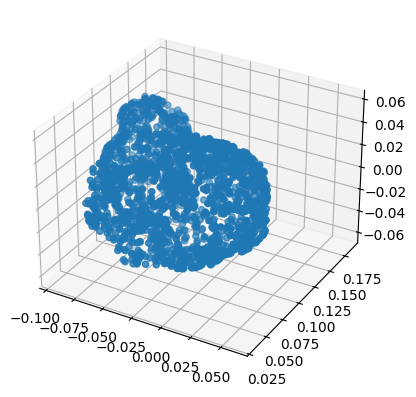

In [21]:
bunny = trimesh.load("Resources/stanford-bunny.obj")
#smple target_points from the bunny
target_points = bunny.sample(2048)

#plot the bunny
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(target_points[:,0], target_points[:,1], target_points[:,2])
plt.show()



loaded model


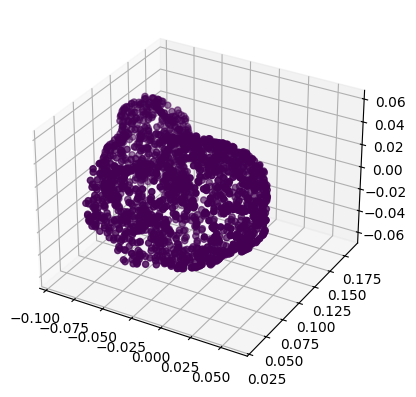

In [ ]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=input_dims).to(device)
model_path = 'models_resources/pretrained_sphere_small.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_sphere(3000)
    torch.save(model.state_dict(),model_path)

In [ ]:
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_true_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
], betas=(0.5, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_true_points = lambda_weights[7]
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute, bisectors_to_compute = su.compute_zero_crossing_vertices(sites, model)
        vertices = su.compute_all_vertices(sites, vertices_to_compute)
        bisectors = su.compute_all_bisectors(sites, bisectors_to_compute)
    
        #combine vertices and bisectors to one tensor for chamfer
        points = torch.cat((vertices, bisectors), 0)

        # Compute losses       
        cvt_loss = lf.compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = lf.chamfer_distance(true_points, points)
        eikonal_loss = lf.eikonal(model)
        domain_restriction_loss = lf.domain_restriction(true_points, model)
        
        sdf_values_true_points = model(true_points)[:,0]
        zero_true_points_loss_L2 = torch.mean(sdf_values_true_points**2)
        zero_true_points_loss_L1 = torch.mean(torch.abs(model(true_points)[:, 0]))
        lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        zero_true_points_loss = lambda_1 * zero_true_points_loss_L1 + lambda_2 * zero_true_points_loss_L2

               
        # Track raw losses (unweighted)
        cvt_loss_values.append(cvt_loss.item())
        min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_true_points_loss_values.append(zero_true_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            lambda_domain_restriction * domain_restriction_loss +
            lambda_true_points * zero_true_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
        
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
            print("sites length: ",len(sites))
            
            new_sites = su.upsampling_inside(best_sites, model)
            #new_sites = su.adaptive_density_upsampling(best_sites, model)
            print(new_sites)
            sites = su.add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0
          
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
        
        epoch += 1           
        
    return best_sites

In [ ]:
lambda_weights = [0.2,0,0.1,0,1.0,0.1,0,2]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_true_points = lambda_weights[7]

max_iter = 500

site_file_path = f'{destination}{max_iter}3d_sites_chamfer{lamda_chamfer}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)    
else:
    sites = autograd(sites, model, max_iter=max_iter, upsampling=2, lambda_weights=lambda_weights)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)